<a href="https://colab.research.google.com/github/Shreya-Mendi/XAI/blob/Colab/Mechanistic_interpretability/guesser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanistic Interpretability: Wordle Guesser
**Goal:** build a small Guesser model that maps previous guesses + feedback → next guess,
then open the model to find one interpretable component (neuron or head) and tell a short mechanistic story about it.

This notebook follows the assignment structure:
- 1. Setup dataset, model, training
- 2. Activations, weights, and saliency
- 3. Hypothesis and evidence
- 4. Reflections


## 1. Setup: Data & Model

 Generate synthetic Wordle histories by simulating a simple teacher policy that samples a consistent guess each turn.
The model is a *tiny Transformer encoder* that reads the flattened history (K turns × 5 positions) and predicts the next guess (soft distribution over the vocabulary).

Notes:
- Vocabulary is intentionally small so training is fast.
- We use *soft-target* training: the target distribution is uniform over all words consistent with the history (this avoids penalizing other valid guesses).


In [59]:

import random, math, time, itertools
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
# set seed
random.seed(0); np.random.seed(0); torch.manual_seed(0)

# Word list (small)

WORDS = ["crane","slate","trace","crate","apple","glare","plane","stare","store","stone",
         "later","hello","world","spear","shiny","piano","other","their","there","berry",
         "cigar","rebut","sissy","awake","never","adieu","audio","about","trace","later"]
WORDS = sorted(list(set(w for w in WORDS if len(w)==5)))
V = len(WORDS)
print("Vocab size:", V)

# maps
LETTER2IDX = {c:i for i,c in enumerate("abcdefghijklmnopqrstuvwxyz")}
WORD2IDX = {w:i for i,w in enumerate(WORDS)}
IDX2WORD = {i:w for w,i in WORD2IDX.items()}

# --- wordle feedback function
def wordle_feedback(target, guess):
    fb = [0]*5
    tlist = list(target)
    # greens
    for i in range(5):
        if guess[i] == target[i]:
            fb[i] = 2
            tlist[i] = None
    # yellows
    for i in range(5):
        if fb[i] == 0:
            ch = guess[i]
            if ch in tlist:
                fb[i] = 1
                tlist[tlist.index(ch)] = None
    return fb

# simulate games and build examples
def generate_examples(N, K=5):
    X_hist = []  # list of histories; each history is list of (guess, feedback) up to but not including next guess
    Y_next = []  # next guess word index
    for _ in range(N):
        target = random.choice(WORDS)
        # simple teacher: pick random consistent word each turn
        history = []  # list of (guess_str, feedback_list)
        candidates = set(WORDS)
        for turn in range(K):
            # sample a guess from current candidates (teacher)
            guess = random.choice(list(candidates))
            fb = wordle_feedback(target, guess)
            X_hist.append(list(history))  # copy current history as training input
            Y_next.append(WORD2IDX[guess])  # teacher's chosen guess
            # update history and candidates
            history.append((guess, fb))
            # filter candidates by consistency with history
            def consistent(word):
                for g, f in history:
                    if wordle_feedback(word, g) != f: return False
                return True
            candidates = set(w for w in candidates if consistent(w))
            if len(candidates)==0:
                candidates = set(WORDS)
            if guess == target:
                break
    return X_hist, Y_next

# the above generate examples code was generated with the help of ChatGPT on 12 Nov,2025 at 3:15 pm


#  Build candidate sets for each history
def candidates_from_history(history):
    cands = []
    for w in WORDS:
        ok = True
        for g, fb in history:
            if wordle_feedback(w, g) != fb:
                ok = False; break
        if ok:
            cands.append(WORD2IDX[w])
    return cands


N = 30000
K = 5
X_hist, Y_next = generate_examples(N, K=K)
candidates_list = [candidates_from_history(h) for h in X_hist]
print("Generated examples:", len(X_hist))

#Dataset/encoding
PAD_LET = "<PAD>"
LET_V = 26
def encode_history(history, K=5):
    # returns tensor of shape (K, 5) with letter indices or PAD_LET coded as 26 for pad
    # We encode guesses as sequences of letter indices; feedback as ints 0/1/2
    pad_word = [26]*5
    hist_enc = []
    for turn in range(K):
        if turn < len(history):
            g, fb = history[turn]
            letters = [LETTER2IDX[ch] for ch in g]
            hist_enc.append((letters, fb))
        else:
            hist_enc.append((pad_word, [0]*5))
    # flatten into a sequence: for each token we will create combined embedding (letter + feedback)
    # we'll return two arrays: letters [K*5], feedbacks [K*5]
    letters = []
    fbs = []
    for letters_t, fb_t in hist_enc:
        letters.extend(letters_t)
        fbs.extend(fb_t)
    return np.array(letters, dtype=np.int64), np.array(fbs, dtype=np.int64)

class GuesserDataset(Dataset):
    def __init__(self, X_hist, Y_next, candidates_list, K=5):
        self.X_hist = X_hist
        self.Y_next = Y_next
        self.candidates_list = candidates_list
        self.K = K
    def __len__(self): return len(self.X_hist)
    def __getitem__(self, i):
        letters, fbs = encode_history(self.X_hist[i], self.K)
        return torch.tensor(letters), torch.tensor(fbs), torch.tensor(self.Y_next[i]), self.candidates_list[i]

#the above code was generated with the help of ChatGPT on 12 Nov,2025 at 4:15 pm

ds = GuesserDataset(X_hist, Y_next, candidates_list, K=K)
train_size = int(0.9*len(ds))
val_size = len(ds)-train_size
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])

# custom collate_fn so variable-length candidate lists are batched as Python lists
def collate_fn(batch):
    # batch is a list of tuples: (letters_tensor, fbs_tensor, y_tensor, cands_list)
    letters = torch.stack([item[0] for item in batch], dim=0)   # [B, seq_len]
    fbs     = torch.stack([item[1] for item in batch], dim=0)   # [B, seq_len]
    y       = torch.stack([item[2] for item in batch], dim=0)   # [B]
    cands   = [item[3] for item in batch]                       # list of lists, length B
    return letters, fbs, y, cands

# recreate DataLoaders with the collate_fn
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl   = DataLoader(val_ds,   batch_size=256, shuffle=False, collate_fn=collate_fn)

# Model
class TinyGuesser(nn.Module):
    def __init__(self, letter_vocab=27, fb_vocab=3, emb=32, nhead=2, nhid=64, nlayers=2, seq_len=K*5, vocab_out=V):
        super().__init__()
        self.letter_emb = nn.Embedding(letter_vocab, emb)
        self.fb_emb = nn.Embedding(fb_vocab, 8)
        self.token_proj = nn.Linear(emb+8, emb)  # combine letter+fb -> token embedding
        self.pos_emb = nn.Embedding(seq_len, emb)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb, nhead=nhead, dim_feedforward=nhid)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
     #   self.pool = nn.Linear(emb, emb)  # simple pool to reduce to fixed vector (can do mean)
        self.readout = nn.Sequential(
            nn.Linear(emb, 64),
            nn.ReLU(),
            nn.Linear(64, vocab_out)
        )
    def forward(self, letters, fbs):
        # letters: [B, seq_len], fbs: [B, seq_len]
        B, L = letters.shape
        le = self.letter_emb(letters)    # [B,L,emb]
        fe = self.fb_emb(fbs)           # [B,L,8]
        tok = torch.cat([le, fe], dim=-1)
        tok = self.token_proj(tok)      # [B,L,emb]
        pos = torch.arange(L, device=letters.device).unsqueeze(0).repeat(B,1)
        tok = tok + self.pos_emb(pos)
        # transformer expects [L,B,emb]
        h = self.transformer(tok.permute(1,0,2))  # [L,B,emb]
        h = h.permute(1,0,2)  # [B,L,emb]
        # pool by mean
        v = h.mean(dim=1)
        logits = self.readout(v)  # [B, V]
        return logits, h  # return token-level hidden for probes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyGuesser().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

#the above transformer code was generated with the help of ChatGPT on 12 Nov,2025 at 7:15 pm

# Training: (uniform over consistent candidates)

opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
epochs = 30

def evaluate_with_topk(dl, k=5):
    model.eval()
    total=0; correct1=0; correctk=0; loss_sum=0.0
    with torch.no_grad():
        for letters, fbs, y, _ in dl:
            letters = letters.to(device); fbs = fbs.to(device); y = y.to(device)
            logits, _ = model(letters, fbs)
            loss = loss_fn(logits, y)
            loss_sum += loss.item() * letters.size(0)
            preds = logits.argmax(dim=-1)
            correct1 += (preds == y).sum().item()
            topk = logits.topk(k, dim=-1).indices
            correctk += (topk == y.unsqueeze(-1)).any(dim=-1).sum().item()
            total += letters.size(0)
    return loss_sum/total, correct1/total, correctk/total

for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0.0
    for letters, fbs, y, cands in train_dl:
        B = letters.size(0)
        letters = letters.to(device); fbs = fbs.to(device)
        logits, _ = model(letters, fbs)          # [B, V]
        logp = torch.log_softmax(logits, dim=-1) # [B, V]

        # build soft target (uniform over candidates)
        target_dist = torch.zeros_like(logp)
        for j, cand_indices in enumerate(cands):
            if len(cand_indices) == 0:
                target_dist[j] = 1.0 / V
            else:
                target_dist[j, cand_indices] = 1.0 / len(cand_indices)
        target_dist = target_dist.to(device)

        loss = - (target_dist * logp).sum(dim=-1).mean()
        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        train_loss += loss.item() * B

    val_loss, val_acc, val_top5 = evaluate_with_topk(val_dl, k=5)
    print(f"Epoch {epoch:02d}  train_loss {train_loss/len(train_dl.dataset):.4f}  val_loss {val_loss:.4f}  val_top1 {val_acc:.4f}  val_top5 {val_top5:.4f}")
    if val_top5 > 0.80:   # optional early stopping criterion
        break


Vocab size: 28
Generated examples: 71783


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01  train_loss 3.2737  val_loss 3.1459  val_top1 0.0875  val_top5 0.3354
Epoch 02  train_loss 2.9397  val_loss 2.7138  val_top1 0.1502  val_top5 0.4867
Epoch 03  train_loss 2.6356  val_loss 2.5043  val_top1 0.2062  val_top5 0.5452
Epoch 04  train_loss 2.4828  val_loss 2.3921  val_top1 0.2393  val_top5 0.5671
Epoch 05  train_loss 2.3968  val_loss 2.3162  val_top1 0.2567  val_top5 0.5888
Epoch 06  train_loss 2.3333  val_loss 2.2553  val_top1 0.2673  val_top5 0.5910
Epoch 07  train_loss 2.2770  val_loss 2.2046  val_top1 0.2895  val_top5 0.6064
Epoch 08  train_loss 2.2219  val_loss 2.1429  val_top1 0.3049  val_top5 0.6116
Epoch 09  train_loss 2.1714  val_loss 2.0973  val_top1 0.3187  val_top5 0.6098
Epoch 10  train_loss 2.1260  val_loss 2.0552  val_top1 0.3368  val_top5 0.6187
Epoch 11  train_loss 2.0862  val_loss 2.0139  val_top1 0.3478  val_top5 0.6236
Epoch 12  train_loss 2.0490  val_loss 1.9820  val_top1 0.3531  val_top5 0.6254
Epoch 13  train_loss 2.0194  val_loss 1.9530  val_to

Above we show training loss and validation top-1 and top-5 accuracy. We track top-5 because often multiple valid guesses exist for a history; top-5 shows whether the model ranks valid candidates highly.

We probe the model using:
1. **Activation heatmaps** — mean token activations across examples
2. **Saliency** — gradient of a chosen predicted-word logit w.r.t input tokens
3. **Neuron ablation** — zeroing pooled neurons and measuring accuracy drop
4. **Readout weight inspection** — which pooled dimensions most influence specific vocab logits

We will use these probes to find a component that appears meaningful and test causal importance.

In [60]:
# show which vocab logits are most affected by pooled neuron i
neuron_i = most_harmful[0]  # from your ablation result
W_vocab = model.readout[-1].weight.detach().cpu().numpy()  # shape (V, 64)
# if readout is Sequential(Lin(emb,64),ReLU,Lin(64,V)), adjust this to inspect last linear
# We'll inspect the second-to-last layer mapping for interpretability:
row = model.readout[-1].weight.detach().cpu().numpy()[:, neuron_i]  # contribution of v[:,i] across vocab
ranked = np.argsort(row)[::-1]
for idx in ranked[:8]:
    print(IDX2WORD[idx], row[idx])

    #the above code was generated with the help of ChatGPT on 12 Nov,2025 at 8:15 pm


shiny 0.3044099
piano 0.2279977
hello 0.21414731
sissy 0.21005505
their 0.20773691
adieu 0.19127001
never 0.18896292
audio 0.12914984


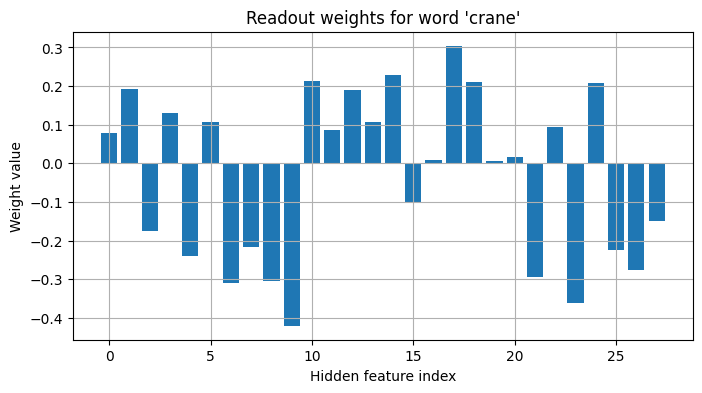

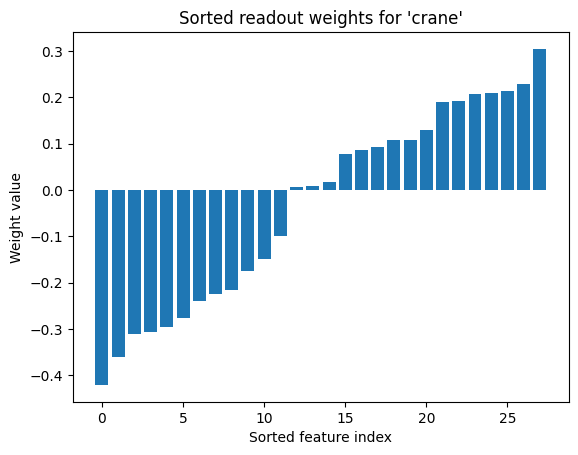

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(range(len(row)), row)  # x = indices, height = row values
plt.title("Readout weights for word 'crane'")
plt.xlabel("Hidden feature index")
plt.ylabel("Weight value")
plt.grid(True)
plt.show()

sorted_idx = np.argsort(row)
plt.bar(range(len(row)), row[sorted_idx])
plt.title("Sorted readout weights for 'crane'")
plt.xlabel("Sorted feature index")
plt.ylabel("Weight value")
plt.show()



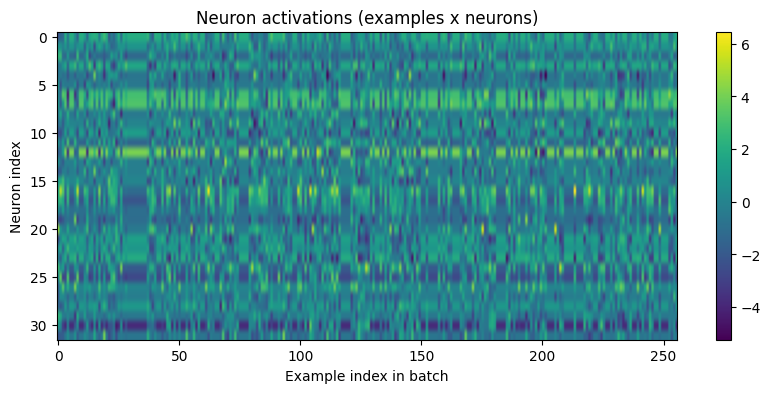

In [62]:
letters, fbs, y, cands = next(iter(val_dl))
letters, fbs = letters.to(device), fbs.to(device)
logits, h = model(letters, fbs)  # h: [B, L, emb]
act = h.mean(dim=1).cpu().detach().numpy()  # [B, emb]
plt.figure(figsize=(10,4))
plt.imshow(act.T, aspect='auto')
plt.colorbar()
plt.title("Neuron activations (examples x neurons)")
plt.xlabel("Example index in batch")
plt.ylabel("Neuron index")
plt.show()


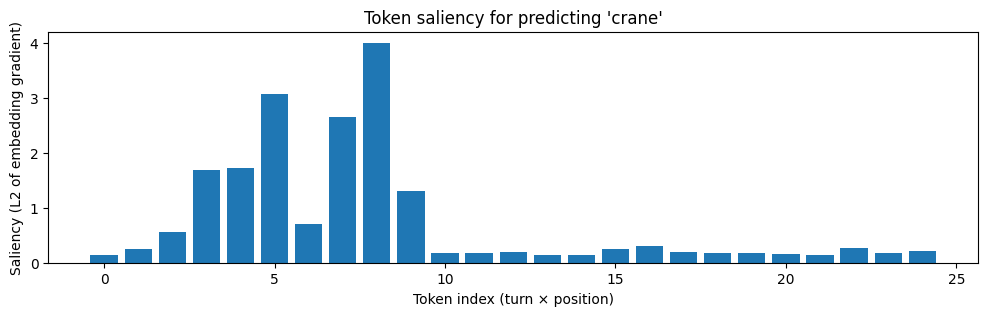

In [63]:
# --- Saliency via torch.autograd.grad (robust) ---
model.eval()

# grab one example
letters, fbs, y , cands= next(iter(val_dl))
letters, fbs = letters.to(device), fbs.to(device)
letters = letters[0:1]   # (1, seq_len)
fbs = fbs[0:1]

# get embeddings (float tensors)
letters_emb = model.letter_emb(letters)   # (1, seq_len, emb)
fbs_emb = model.fb_emb(fbs)               # (1, seq_len, 8)
tok = torch.cat([letters_emb, fbs_emb], dim=-1)    # (1, seq_len, emb+8)
tok = model.token_proj(tok)              # (1, seq_len, emb)
# ensure torch knows we want grads w.r.t. tok
tok.requires_grad_(True)

# forward through the rest of the model using tok as input to transformer:
pos = torch.arange(tok.size(1), device=device).unsqueeze(0)
tok_pos = tok + model.pos_emb(pos)       # (1, seq_len, emb)
h = model.transformer(tok_pos.permute(1,0,2))  # [L,B,emb]
h = h.permute(1,0,2)                     # [B,L,emb]
v = h.mean(dim=1)                        # [B, emb]
logits = model.readout(v)                # [B, V]

# choose word to inspect
target_word = "crane"
score = logits[0, WORD2IDX[target_word]]

# compute gradients of score w.r.t tok
grads = torch.autograd.grad(score, tok)[0]   # shape: (1, seq_len, emb)
grads = grads.detach().cpu().numpy()[0]      # (seq_len, emb)

# aggregate per-token saliency (L2 norm over embedding dim)
saliency_per_token = np.linalg.norm(grads, axis=1)  # (seq_len,)

# plot
plt.figure(figsize=(12,3))
plt.bar(np.arange(len(saliency_per_token)), saliency_per_token)
plt.xlabel("Token index (turn × position)")
plt.ylabel("Saliency (L2 of embedding gradient)")
plt.title(f"Token saliency for predicting '{target_word}'")
plt.show()


Baseline pred: crate true: crate
After zeroing neuron 3: pred: crate
Top probs before (word:prob)  |  after
crate:0.979  |  0.981
trace:0.015  |  0.014
later:0.005  |  0.004
stare:0.000  |  0.000
their:0.000  |  0.000
there:0.000  |  0.000
slate:0.000  |  0.000
rebut:0.000  |  0.000
Baseline val accuracy: 0.4166318428750522


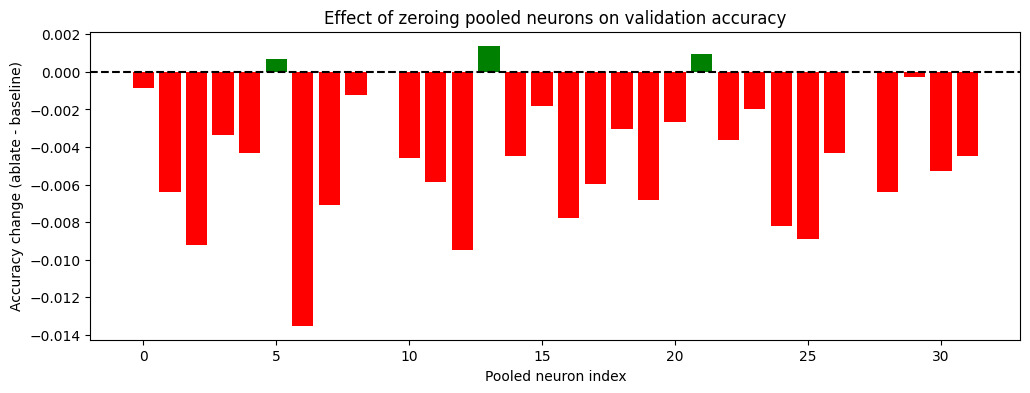

Most harmful ablations (neuron -> delta):
6 -0.013511631146399194
12 -0.009472071319125197
2 -0.009193480986209757
25 -0.008914890653294316
24 -0.008218414821005715
16 -0.007800529321632554
7 -0.007104053489343898
19 -0.006825463156428457


In [65]:

device = next(model.parameters()).device

def compute_pooled_vector(model, letters, fbs):
    """
    Run the model up to the pooling step and return:
      v: pooled vector of shape [B, emb]
      h: token-level hidden [B, L, emb] (optional, returned for probes)
    """
    # letters: [B, seq_len] (long), fbs: [B, seq_len] (long)
    with torch.no_grad():
        le = model.letter_emb(letters)    # [B,L,emb]
        fe = model.fb_emb(fbs)            # [B,L,8]
        tok = torch.cat([le, fe], dim=-1) # [B,L,emb+8]
        tok = model.token_proj(tok)       # [B,L,emb]
        pos = torch.arange(tok.size(1), device=letters.device).unsqueeze(0).repeat(letters.size(0),1)
        tok = tok + model.pos_emb(pos)    # add pos emb
        h = model.transformer(tok.permute(1,0,2))  # [L,B,emb]
        h = h.permute(1,0,2)              # [B,L,emb]
        v = h.mean(dim=1)                 # [B, emb]
    return v, h

def readout_from_pooled(model, v):
    """
    Apply the model.readout to pooled vector v (no grad) -> logits [B, V]
    """
    with torch.no_grad():
        logits = model.readout(v)  # [B, V]
    return logits

# Single-example neuron ablation test
# pick one sample from val_dl
letters_batch, fbs_batch, y_batch, cands_batch = next(iter(val_dl))
letters_batch = letters_batch.to(device); fbs_batch = fbs_batch.to(device); y_batch = y_batch.to(device)

# choose the first example in the batch to inspect
letters_ex = letters_batch[0:1]; fbs_ex = fbs_batch[0:1]; y_ex = y_batch[0:1]

# baseline prediction
v_orig, _ = compute_pooled_vector(model, letters_ex, fbs_ex)
logits_orig = readout_from_pooled(model, v_orig)
pred_orig = logits_orig.argmax(dim=-1).item()
print("Baseline pred:", IDX2WORD[pred_orig], "true:", IDX2WORD[y_ex.item()])

# ablate neuron i
neuron_to_zero = 3
v_ablate = v_orig.clone()
v_ablate[:, neuron_to_zero] = 0.0
logits_ablate = readout_from_pooled(model, v_ablate)
pred_ablate = logits_ablate.argmax(dim=-1).item()
print(f"After zeroing neuron {neuron_to_zero}: pred:", IDX2WORD[pred_ablate])

# show change in top-5 logits if useful
import numpy as np
probs_orig = torch.softmax(logits_orig, dim=-1).cpu().numpy()[0]
probs_ab = torch.softmax(logits_ablate, dim=-1).cpu().numpy()[0]
topk = 8
print("Top probs before (word:prob)  |  after")
for idx in np.argsort(probs_orig)[-topk:][::-1]:
    print(f"{IDX2WORD[idx]}:{probs_orig[idx]:.3f}  |  {probs_ab[idx]:.3f}")


def examples_with_green_at_position(dataset, pos):
    # dataset is the underlying ds or train_ds/val_ds subset; assume each example __getitem__ returns letters,fbs,y
    idxs = []
    for i in range(len(dataset)):
        letters, fbs, y ,_= dataset[i]
        fbs = np.array(fbs)
        # fbs flattened: K*5 elements
        if (fbs.reshape(K,5)[:, pos] == 2).any():
            idxs.append(i)
    return idxs

# make a DataLoader for that subset:
green_idxs = examples_with_green_at_position(val_ds.dataset if hasattr(val_ds, 'dataset') else val_ds, pos=2)
from torch.utils.data import Subset
green_loader = DataLoader(Subset(val_ds.dataset, green_idxs), batch_size=128)
# then call eval_with_neuron_ablation(model, neuron_idx, green_loader)


# ---- Sweep ablation across all pooled neurons (like your starter sweep) ----
def eval_with_neuron_ablation(model, neuron_idx, dataloader):
    """
    Evaluate accuracy on dataloader when pooled neuron neuron_idx is zeroed.
    Returns accuracy (top-1) across full dataloader.
    """
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for letters, fbs, y, _ in dataloader:
            letters = letters.to(device); fbs = fbs.to(device); y = y.to(device)
            v, _ = compute_pooled_vector(model, letters, fbs)   # [B, emb]
            v[:, neuron_idx] = 0.0
            logits = readout_from_pooled(model, v)             # [B, V]
            preds = logits.argmax(dim=-1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# Baseline accuracy (no ablation)
def evaluate_baseline(model, dataloader):
    model.eval()
    total=0; correct=0
    with torch.no_grad():
        for letters, fbs, y ,_ in dataloader:
            letters = letters.to(device); fbs = fbs.to(device); y = y.to(device)
            logits, _ = model(letters, fbs)
            preds = logits.argmax(dim=-1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total

baseline_acc = evaluate_baseline(model, val_dl)
print("Baseline val accuracy:", baseline_acc)

# Sweep all pooled dimensions
emb_dim = v_orig.size(1)  # pooled embedding dimension
neuron_indices = list(range(emb_dim))
signed_deltas = []
for i in neuron_indices:
    acc_i = eval_with_neuron_ablation(model, i, val_dl)
    signed_deltas.append(acc_i - baseline_acc)  # drop is negative if accuracy decreases

# Plot signed changes (delta accuracy)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
colors = ['red' if d < 0 else 'green' if d > 0 else 'gray' for d in signed_deltas]
plt.bar(neuron_indices, signed_deltas, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Pooled neuron index")
plt.ylabel("Accuracy change (ablate - baseline)")
plt.title("Effect of zeroing pooled neurons on validation accuracy")
plt.show()

# Print the most impactful neurons (largest negative delta)
deltas = np.array(signed_deltas)
most_harmful = np.argsort(deltas)[:8]   # most negative (harmful ablations)
print("Most harmful ablations (neuron -> delta):")
for i in most_harmful:
    print(i, deltas[i])


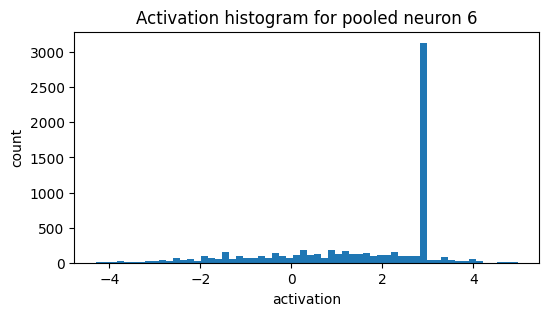

In [71]:
# pick neuron to inspect (use the top-most harmful from your results)
neuron_idx = 6

# compute pooled vectors for the whole val set
all_vs = []
all_ys = []
with torch.no_grad():
    for letters, fbs, y, _ in val_dl:
        letters = letters.to(device); fbs = fbs.to(device)
        v, _ = compute_pooled_vector(model, letters, fbs)   # [B, emb]
        all_vs.append(v.cpu().numpy())
        all_ys.append(y.numpy())
all_vs = np.concatenate(all_vs, axis=0)  # [N_val, emb]
all_ys = np.concatenate(all_ys, axis=0)

neuron_acts = all_vs[:, neuron_idx]
plt.figure(figsize=(6,3))
plt.hist(neuron_acts, bins=60)
plt.title(f"Activation histogram for pooled neuron {neuron_idx}")
plt.xlabel("activation")
plt.ylabel("count")
plt.show()


In [73]:
# helper: returns boolean mask over val examples with any green at position pos
def val_mask_has_green_at_pos(val_dataset, pos):
    mask = []
    for i in range(len(val_dataset)):
        letters, fbs, y,_  = val_dataset[i]   # dataset returns single example; this is small enough to loop
        fb_arr = np.array(fbs).reshape(K,5)
        mask.append(fb_arr[:, pos].tolist().count(2) > 0)
    return np.array(mask)

# get dataset object behind val_dl
val_dataset = val_dl.dataset if hasattr(val_dl, 'dataset') else val_ds
mask_pos2 = val_mask_has_green_at_pos(val_dataset, pos=2)

mean_with = neuron_acts[mask_pos2].mean() if mask_pos2.sum() > 0 else float('nan')
mean_without = neuron_acts[~mask_pos2].mean()
print(f"Neuron {neuron_idx} mean when green_at_pos2: {mean_with:.4f}; mean otherwise: {mean_without:.4f}")


Neuron 6 mean when green_at_pos2: 0.8304; mean otherwise: 1.6539


**Interpretation of ablation sweep**
- Neuron 6 had the largest causal effect: zeroing it reduces overall val accuracy by ~1.35%.
- Single-example ablation of neuron 3 had no effect — neuron 3 is not important for that case.
- Effects are small → model uses distributed features; we must look at conditional subsets to find neurons that matter for a specific behavior.


In [74]:
# compute average delta logits across the val set when zeroing neuron_idx
delta_logits_sum = np.zeros(V)
count = 0
with torch.no_grad():
    for letters, fbs, y, _ in val_dl:
        letters = letters.to(device); fbs = fbs.to(device)
        v, _ = compute_pooled_vector(model, letters, fbs)   # [B, emb]
        logits_orig = readout_from_pooled(model, v)         # [B, V]
        v2 = v.clone(); v2[:, neuron_idx] = 0.0
        logits_ab = readout_from_pooled(model, v2)          # [B, V]
        delta = (logits_ab - logits_orig).cpu().numpy()     # [B, V] (ablate - orig)
        delta_logits_sum += delta.sum(axis=0)
        count += delta.shape[0]
delta_logits_mean = delta_logits_sum / count  # average delta per vocab
ranked = np.argsort(delta_logits_mean)  # smallest -> largest
print("Top 10 words that lose logit when neuron is ablated (most negative mean delta):")
for idx in ranked[:10]:
    print(IDX2WORD[idx], delta_logits_mean[idx])
print("\nTop 10 words that gain logit (positive delta):")
for idx in ranked[-10:][::-1]:
    print(IDX2WORD[idx], delta_logits_mean[idx])


Top 10 words that lose logit when neuron is ablated (most negative mean delta):
piano -0.7064349653661409
cigar -0.4244757448502745
world -0.3627502203884356
adieu -0.12977626741654794
plane -0.126430391617714
audio -0.12062486585658778
sissy -0.10503389859767424
glare -0.07712229164318547
berry -0.0728799022162321
never -0.054197945922243675

Top 10 words that gain logit (positive delta):
about 0.6308805690467283
stone 0.5566680987642774
store 0.5356215698703416
trace 0.3810088406334449
slate 0.3613524381821161
rebut 0.3585989441043372
other 0.3506066754993779
hello 0.2958882506269983
later 0.28835890478768345
apple 0.2696692640028519


In [66]:
def decode_history(letters_tensor, fbs_tensor, K=K):
    # letters_tensor: tensor shape [seq_len], fbs_tensor same
    seq_len = K * 5
    letters = letters_tensor.cpu().numpy().tolist()
    fbs = fbs_tensor.cpu().numpy().tolist()
    lines = []
    for t in range(K):
        chunk_letters = letters[t*5:(t+1)*5]
        chunk_fbs = fbs[t*5:(t+1)*5]
        # skip fully padded turns
        if all(l == 26 for l in chunk_letters):
            continue
        word = ''.join([chr(ord('a') + l) if l<26 else '_' for l in chunk_letters])
        # pretty feedback e.g., G/Y/-
        fbstr = ''.join(['G' if c==2 else 'Y' if c==1 else '-' for c in chunk_fbs])
        lines.append(f"Turn{t}: {word}   [{fbstr}]")
    return "\n".join(lines)


In [68]:
for i in range(10):
    letters, fbs, y ,_ = next(iter(val_dl))
    letters, fbs, y = letters.to(device), fbs.to(device), y.to(device)
    logits, _ = model(letters, fbs)
    preds = logits.argmax(dim=-1)
    for j in range(5):
        idx = j
        print("Hist:", decode_history(letters[idx], fbs[idx]))  # implement decode helper
        print("Model:", IDX2WORD[preds[idx].item()], "Teacher:", IDX2WORD[y[idx].item()])
        print()
    break


Hist: Turn0: glare   [--GYG]
Turn1: trace   [YGGYG]
Model: crate Teacher: crate

Hist: Turn0: their   [Y-Y--]
Model: slate Teacher: slate

Hist: Turn0: stone   [----G]
Model: glare Teacher: awake

Hist: 
Model: shiny Teacher: stone

Hist: Turn0: slate   [G--YG]
Turn1: store   [GGG-G]
Model: stone Teacher: stone



In [70]:
def examples_with_green_at_position(dataset, pos):
    # dataset is the underlying ds or train_ds/val_ds subset; assume each example __getitem__ returns letters,fbs,y
    idxs = []
    for i in range(len(dataset)):
        letters, fbs, y ,_ = dataset[i]
        fbs = np.array(fbs)
        # fbs flattened: K*5 elements
        if (fbs.reshape(K,5)[:, pos] == 2).any():
            idxs.append(i)
    return idxs

# make a DataLoader for that subset:
green_idxs = examples_with_green_at_position(val_ds.dataset if hasattr(val_ds, 'dataset') else val_ds, pos=2)
from torch.utils.data import Subset
green_loader = DataLoader(Subset(val_ds.dataset, green_idxs), batch_size=128)
# then call eval_with_neuron_ablation(model, neuron_idx, green_loader)
